In [1]:
import sys
print("Assignment 2: Neural Language Model (PyTorch) — Notebook Start")
print("Python:", sys.version.splitlines()[0])


import torch
import numpy as np
import random
print("PyTorch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Assignment 2: Neural Language Model (PyTorch) — Notebook Start
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch version: 2.8.0+cu126
Device: cuda


In [2]:
import os, time, math, json, itertools
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
DATA_PATH = Path("data")
DATA_PATH.mkdir(exist_ok=True)
print("Place the provided dataset (plain text) in:", DATA_PATH.resolve())
print("Expected: one text file (utf-8). If you have a dataset folder, set TEXT_FILE variable below.")
TEXT_FILE = DATA_PATH / "dataset.txt"
print("Current TEXT_FILE =", TEXT_FILE)

Place the provided dataset (plain text) in: /content/data
Expected: one text file (utf-8). If you have a dataset folder, set TEXT_FILE variable below.
Current TEXT_FILE = data/dataset.txt


In [4]:
from google.colab import files

print("📤 Please upload your dataset file (e.g., .txt)...")
uploaded = files.upload()

if len(uploaded) == 0:
    print("No file uploaded. Please re-run this cell and upload a text file.")
    raw_text = None
else:
    filename = list(uploaded.keys())[0]
    print(f"✅ File '{filename}' uploaded successfully.")
    with open(filename, "r", encoding="utf-8", errors="ignore") as f:
        raw_text = f.read()
    print("Loaded file size (chars):", len(raw_text))
    n_lines = raw_text.count("\n") + 1
    print("Approx lines:", n_lines)
    print("\nFirst 500 characters:\n")
    print(raw_text[:500])

📤 Please upload your dataset file (e.g., .txt)...


Saving Pride_and_Prejudice-Jane_Austen.txt to Pride_and_Prejudice-Jane_Austen.txt
✅ File 'Pride_and_Prejudice-Jane_Austen.txt' uploaded successfully.
Loaded file size (chars): 711331
Approx lines: 13713

First 500 characters:

The Project Gutenberg eBook, Pride and Prejudice, by Jane Austen, Edited
by R. W. (Robert William) Chapman


This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org





Title: Pride and Prejudice


Author: Jane Austen

Editor: R. W. (Robert William) Chapman

Release Date: May 9, 2013  [eBook #42671]

Lang


In [5]:
class Tokenizer:
    def __init__(self, min_freq=1, unk_token="<unk>", pad_token="<pad>", bos_token="<bos>", eos_token="<eos>"):
        self.min_freq = min_freq
        self.unk_token = unk_token
        self.pad_token = pad_token
        self.bos_token = bos_token
        self.eos_token = eos_token
        self.token_to_id = {}
        self.id_to_token = {}
        self.fitted = False

    @staticmethod
    def simple_tokenize(text):
        return text.strip().split()

    def fit(self, texts):
        counter = Counter()
        for t in texts:
            counter.update(self.simple_tokenize(t))
        vocab = [self.pad_token, self.unk_token, self.bos_token, self.eos_token]
        for tok, freq in counter.most_common():
            if freq >= self.min_freq:
                vocab.append(tok)
        self.token_to_id = {tok: idx for idx, tok in enumerate(vocab)}
        self.id_to_token = {idx: tok for tok, idx in self.token_to_id.items()}
        self.fitted = True
        print(f"Vocab size: {len(self.token_to_id)} (min_freq={self.min_freq})")
        return self

    def encode(self, text):
        if not self.fitted:
            raise RuntimeError("Tokenizer not fitted")
        toks = self.simple_tokenize(text)
        ids = [self.token_to_id.get(tok, self.token_to_id[self.unk_token]) for tok in toks]
        return ids

    def decode(self, ids):
        return " ".join(self.id_to_token.get(i, self.unk_token) for i in ids)

In [6]:
if raw_text is None:
    print("No raw_text loaded; abort tokenization step.")
else:
    lines = [ln.strip() for ln in raw_text.splitlines() if ln.strip()]
    print("Effective text units:", len(lines))

    tokenizer = Tokenizer(min_freq=1)
    tokenizer.fit(lines)

    tokenized_lines = [tokenizer.encode(ln) for ln in lines]

    stream = []
    for seq in tokenized_lines:
        stream.append(tokenizer.token_to_id[tokenizer.bos_token])
        stream.extend(seq)
        stream.append(tokenizer.token_to_id[tokenizer.eos_token])
    print("Total tokens in stream:", len(stream))

Effective text units: 11170
Vocab size: 13781 (min_freq=1)
Total tokens in stream: 147310


In [7]:
class LangModelDataset(Dataset):
    def __init__(self, token_stream, seq_len):
        self.seq_len = seq_len
        self.stream = token_stream
        self.examples = []
        total = len(token_stream)
        for i in range(total - seq_len):
            x = token_stream[i:i+seq_len]
            y = token_stream[i+1:i+seq_len+1]
            self.examples.append((x, y))
        print(f"Created {len(self.examples)} examples (seq_len={seq_len})")

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        x, y = self.examples[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

def collate_batch(batch):
    xs, ys = zip(*batch)
    x = torch.stack(xs)
    y = torch.stack(ys)
    return x, y

In [8]:
if raw_text is not None:
    total_tokens = len(stream)
    split_at = int(0.9 * total_tokens)
    train_stream = stream[:split_at]
    val_stream = stream[split_at:]
    print("Train tokens:", len(train_stream), "Val tokens:", len(val_stream))
    DEFAULT_SEQ_LEN = 30

    train_ds_tmp = LangModelDataset(train_stream, seq_len=DEFAULT_SEQ_LEN)
    val_ds_tmp = LangModelDataset(val_stream, seq_len=DEFAULT_SEQ_LEN)

Train tokens: 132579 Val tokens: 14731
Created 132549 examples (seq_len=30)
Created 14701 examples (seq_len=30)


In [9]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, emb_size=128, hidden_size=256, num_layers=1, dropout=0.1, tie_weights=False):
        super().__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.lstm = nn.LSTM(emb_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers>1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

        if tie_weights:
            if hidden_size != emb_size:
                raise ValueError("For weight tying, embedding dim must equal hidden size")
            self.fc.weight = self.embedding.weight

    def forward(self, x, hidden=None):
        emb = self.embedding(x)
        out, hidden = self.lstm(emb, hidden)
        out = self.dropout(out)
        logits = self.fc(out)
        return logits, hidden

    def init_hidden(self, batch_size, device):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
        return (h0, c0)

In [10]:
criterion = nn.CrossEntropyLoss(ignore_index=-100)


def compute_perplexity(loss):
    return math.exp(loss)

def sequence_loss_and_perplexity(logits, targets):
    vocab = logits.size(-1)
    logits_flat = logits.view(-1, vocab)
    targets_flat = targets.view(-1)
    loss = criterion(logits_flat, targets_flat)
    ppl = compute_perplexity(loss.item())
    return loss, ppl

In [11]:
def train_one_epoch(model, dataloader, optimizer, device, clip_grad=None, grad_accum_steps=1):
    model.train()
    total_loss = 0.0
    total_tokens = 0
    hidden = None
    for i, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        batch_size = x.size(0)

        optimizer.zero_grad()
        logits, hidden = model(x, hidden=None)
        loss, _ = sequence_loss_and_perplexity(logits, y)
        loss.backward()
        if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step()

        total_loss += loss.item() * (x.numel() / x.size(-1))
        total_tokens += x.numel()
        hidden = None

    avg_loss = total_loss / total_tokens * dataloader.dataset.seq_len
    avg_loss = total_loss / (len(dataloader) * dataloader.dataset.seq_len)
    return avg_loss

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device); y = y.to(device)
            logits, _ = model(x)
            loss, _ = sequence_loss_and_perplexity(logits, y)
            total_loss += loss.item() * x.size(0)
            total_tokens += x.numel()
    avg_loss = total_loss / (len(dataloader) * dataloader.dataset.seq_len)
    ppl = compute_perplexity(avg_loss)
    return avg_loss, ppl

In [12]:
def run_experiment(config, train_stream, val_stream, tokenizer, device):
    print("Experiment config:", json.dumps(config, indent=2))
    seq_len = config.get("seq_len", DEFAULT_SEQ_LEN)
    train_ds = LangModelDataset(train_stream, seq_len=seq_len)
    val_ds = LangModelDataset(val_stream, seq_len=seq_len)
    train_dl = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True, collate_fn=collate_batch)
    val_dl = DataLoader(val_ds, batch_size=config["batch_size"], shuffle=False, collate_fn=collate_batch)

    vocab_size = len(tokenizer.token_to_id)
    model = LSTMLanguageModel(vocab_size=vocab_size,
                              emb_size=config.get("emb_size", 128),
                              hidden_size=config.get("hidden_size", 256),
                              num_layers=config.get("num_layers", 1),
                              dropout=config.get("dropout", 0.1),
                              tie_weights=config.get("tie_weights", False)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.get("lr", 1e-3), weight_decay=config.get("weight_decay", 0.0))

    best_val_loss = float("inf")
    history = {"train_loss": [], "val_loss": [], "val_ppl": []}
    for epoch in range(1, config["epochs"] + 1):
        start = time.time()
        train_loss = train_one_epoch(model, train_dl, optimizer, device, clip_grad=config.get("clip_grad", None))
        val_loss, val_ppl = evaluate(model, val_dl, device)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_ppl"].append(val_ppl)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()

        print(f"Epoch {epoch}/{config['epochs']}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_ppl={val_ppl:.2f}, time={time.time()-start:.1f}s")
    result = {"config": config, "model_state": best_state, "history": history, "vocab": tokenizer.token_to_id}
    return result

In [13]:
underfit_cfg = {
    "name": "underfit",
    "seq_len": 20,
    "emb_size": 32,
    "hidden_size": 32,
    "num_layers": 1,
    "dropout": 0.5,
    "tie_weights": False,
    "batch_size": 128,
    "lr": 5e-3,
    "weight_decay": 0.0,
    "epochs": 6,
    "clip_grad": 1.0
}

overfit_cfg = {
    "name": "overfit",
    "seq_len": 30,
    "emb_size": 256,
    "hidden_size": 512,
    "num_layers": 2,
    "dropout": 0.0,
    "tie_weights": False,
    "batch_size": 16,
    "lr": 1e-3,
    "weight_decay": 0.0,
    "epochs": 20,
    "clip_grad": None
}

best_fit_cfg = {
    "name": "best_fit",
    "seq_len": 30,
    "emb_size": 128,
    "hidden_size": 256,
    "num_layers": 2,
    "dropout": 0.2,
    "tie_weights": False,
    "batch_size": 64,
    "lr": 1e-3,
    "weight_decay": 1e-5,
    "epochs": 12,
    "clip_grad": 1.0
}

configs = [underfit_cfg, overfit_cfg, best_fit_cfg]

In [14]:
results = {}
for cfg in configs:
    print("\n\n=== Running:", cfg["name"], "===\n")
    res = run_experiment(cfg, train_stream, val_stream, tokenizer, device)
    results[cfg["name"]] = res
    out_dir = Path("trained_models")
    out_dir.mkdir(exist_ok=True)
    model_path = out_dir / f"lm_{cfg['name']}.pt"
    torch.save({"state_dict": res["model_state"], "vocab": res["vocab"], "config": cfg}, model_path)
    print("Saved best model for", cfg["name"], "to", model_path)



=== Running: underfit ===

Experiment config: {
  "name": "underfit",
  "seq_len": 20,
  "emb_size": 32,
  "hidden_size": 32,
  "num_layers": 1,
  "dropout": 0.5,
  "tie_weights": false,
  "batch_size": 128,
  "lr": 0.005,
  "weight_decay": 0.0,
  "epochs": 6,
  "clip_grad": 1.0
}
Created 132559 examples (seq_len=20)
Created 14711 examples (seq_len=20)
Epoch 1/6: train_loss=36.8142, val_loss=40.7387, val_ppl=492688148414461504.00, time=14.2s
Epoch 2/6: train_loss=32.0732, val_loss=41.9429, val_ppl=1642708129644804608.00, time=13.3s
Epoch 3/6: train_loss=30.5838, val_loss=43.2765, val_ppl=6233641066436442112.00, time=13.2s
Epoch 4/6: train_loss=29.7233, val_loss=44.7509, val_ppl=27230824559551098880.00, time=13.2s
Epoch 5/6: train_loss=29.1584, val_loss=46.3216, val_ppl=130983297953269432320.00, time=13.2s
Epoch 6/6: train_loss=28.7420, val_loss=47.8915, val_ppl=629540388923141521408.00, time=13.2s
Saved best model for underfit to trained_models/lm_underfit.pt


=== Running: overfit =

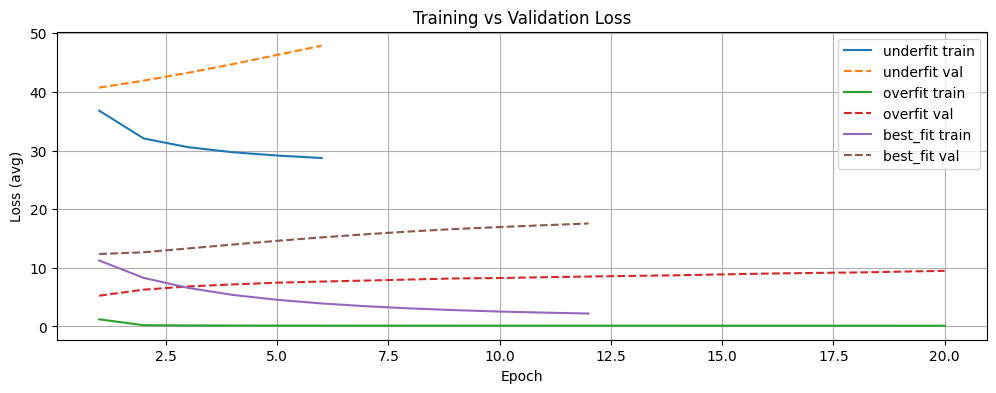

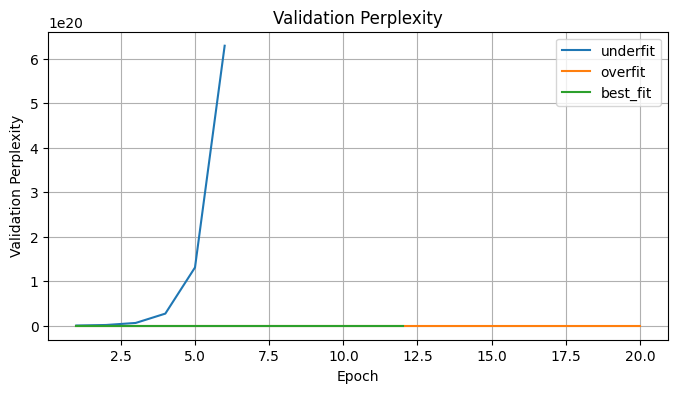

In [15]:
plt.figure(figsize=(12, 4))
for name, res in results.items():
    hist = res["history"]
    epochs = range(1, len(hist["train_loss"]) + 1)
    plt.plot(epochs, hist["train_loss"], label=f"{name} train")
    plt.plot(epochs, hist["val_loss"], "--", label=f"{name} val")
plt.xlabel("Epoch")
plt.ylabel("Loss (avg)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
for name, res in results.items():
    plt.plot(range(1, len(res["history"]["val_ppl"]) + 1), res["history"]["val_ppl"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Validation Perplexity")
plt.title("Validation Perplexity")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
import shutil
from google.colab import files

shutil.make_archive("trained_models", "zip", "trained_models")
print("📦 created trained_models.zip")

files.download("trained_models.zip")

📦 created trained_models.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
for name, res in results.items():
    final_epoch = len(res["history"]["val_ppl"])
    final_ppl = res["history"]["val_ppl"][-1]
    best_ppl = min(res["history"]["val_ppl"])
    best_epoch = res["history"]["val_ppl"].index(best_ppl) + 1
    print(f"{name}: final val PPL={final_ppl:.2f}, best val PPL={best_ppl:.2f} (epoch {best_epoch})")

underfit: final val PPL=629540388923141521408.00, best val PPL=492688148414461504.00 (epoch 1)
overfit: final val PPL=13309.51, best val PPL=190.72 (epoch 1)
best_fit: final val PPL=42735914.11, best val PPL=236126.76 (epoch 1)


In [17]:
def load_model_from_result(res, device):
    cfg = res["config"]
    vocab = res["vocab"]
    inv_vocab = {i:t for t,i in vocab.items()}
    model = LSTMLanguageModel(vocab_size=len(vocab),
                              emb_size=cfg.get("emb_size",128),
                              hidden_size=cfg.get("hidden_size",256),
                              num_layers=cfg.get("num_layers",1),
                              dropout=cfg.get("dropout",0.1)).to(device)
    model.load_state_dict(res["model_state"])
    model.eval()
    return model, vocab, inv_vocab

def generate_text(model, vocab, inv_vocab, tokenizer, seed_text, max_len=30, device=device):
    model.eval()
    ids = [tokenizer.token_to_id.get(tokenizer.bos_token)]
    ids += tokenizer.encode(seed_text)
    input_ids = torch.tensor([ids[-config_seq_len:]], dtype=torch.long).to(device) if (config_seq_len := 30) else torch.tensor([ids], dtype=torch.long).to(device)
    generated = ids.copy()
    with torch.no_grad():
        for _ in range(max_len):
            x = torch.tensor([generated[-30:]], dtype=torch.long).to(device)
            logits, _ = model(x)
            next_logits = logits[0, -1, :]
            next_id = torch.argmax(next_logits).item()
            generated.append(next_id)
            if inv_vocab.get(next_id) == tokenizer.eos_token:
                break
    return tokenizer.decode(generated)

best_name = "best_fit" if "best_fit" in results else list(results.keys())[0]
model_obj, vocab_map, inv_vocab_map = load_model_from_result(results[best_name], device)
sample = "This"
print("Generated (greedy) starting with 'This':")
print(generate_text(model_obj, vocab_map, inv_vocab_map, tokenizer, sample, max_len=40))

Generated (greedy) starting with 'This':
<bos> This was not conciliating, nor was her manner of receiving them, such as <eos>
